## Mount Drive

In [ ]:
# mount drive only needed when executed in colab with colab linked to google drive
# if not on colab/drive, start with Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pwd

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# drive.flush_and_unmount() #in order to reset drive setups

# Import Packages

In [1]:
#Import libraries

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sn
from imutils import paths
import numpy as np
import shutil
import os
import torch

import re
import math
import random
import pandas as pd
import copy

import torchvision
import torch.nn.functional as F

In [2]:
# Device selection(GPU or CPU)
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Load Data


### Splitting Dataset into Training and Validation set

In [ ]:
# code sections marked with JH are from Johannes Hertzler, all other sections are from Inês Vieira

In [3]:
# Splitting Dataset into Training and Validation set

class config:
    # specify path to the dataset
    # DATASET_PATH = "drive/MyDrive/bark_photos"
    DATASET_PATH = "data/BarkNet"

    # path for saving output
    OUTPUT = "output"
    
    # specify the paths to our training and validation set 
    # TRAIN = "train"
    # VAL = "val"
    TRAIN = "data/train"
    VAL = "data/val"

    # TRAINED = "drive/MyDrive/trained"

    # independent test data set
    # INDTEST = "drive/MyDrive/ind_test"
    INDTEST = "data/ind_test"

    # set the crop size
    INPUT_CROPSIZE = 224

    # set the batch size and validation data split
    BATCH_SIZE = 8
    TRAIN_BATCH_SIZE = 32
    VAL_BATCH_SIZE = 100
    VAL_SPLIT = 0.1

    # number of subprocesses in dataLoaders
    WORKERS = 2

In [4]:
if not os.path.exists(config.OUTPUT):
  os.makedirs(config.OUTPUT)

In [5]:
def copy_images(imagePaths, folder):
	# check if the destination folder exists and if not create it
	if not os.path.exists(folder):
		os.makedirs(folder)

	# loop over the image paths
	for path in imagePaths:
		# grab image name and its label from the path and create
		# a placeholder corresponding to the separate label folder
		imageName = path.split(os.path.sep)[-1]
		label = path.split(os.path.sep)[-2]
		labelFolder = os.path.join(folder, label)

		# check to see if the label folder exists and if not create it
		if not os.path.exists(labelFolder):
			os.makedirs(labelFolder)

		# construct the destination image path and copy the current
		# image to it
		destination = os.path.join(labelFolder, imageName)
		shutil.copy(path, destination)

In [6]:
# load all the image paths and randomly shuffle them
print("[INFO] loading image paths...")
# imagePaths = list(paths.list_images(config.DATASET_PATH))
# np.random.shuffle(imagePaths)


# filter classes that will not be used
imagePaths = list(paths.list_images(config.DATASET_PATH))

imagePaths_filtered_1 = [path for path in imagePaths 
                         if path.find('ERB') == -1]
imagePaths_filtered_2 = [path for path in imagePaths_filtered_1 
                         if path.find('PID') == -1]
imagePaths_filtered = [path for path in imagePaths_filtered_2 
                       if path.find('PEG') == -1]

np.random.shuffle(imagePaths_filtered)


# generate training and validation paths
valPathsLen = int(len(imagePaths_filtered) * config.VAL_SPLIT)
trainPathsLen = len(imagePaths_filtered) - valPathsLen
trainPaths = imagePaths_filtered[:trainPathsLen]
valPaths = imagePaths_filtered[trainPathsLen:]

# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, config.TRAIN)
copy_images(valPaths, config.VAL)
print("Done")

[INFO] loading image paths...
[INFO] copying training and validation images...
Done


Image Transformations

In [7]:
# initialize our data augmentation functions
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)
crop = transforms.RandomCrop(config.INPUT_CROPSIZE)
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([crop, hFlip, vFlip, rotate,transforms.ToTensor(), normalize])
valTransforms = transforms.Compose([crop, transforms.ToTensor(), normalize])

### initialize data sets

In [8]:
# initialzie the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root=config.TRAIN, transform=trainTransforms)
valDataset = ImageFolder(root=config.VAL, transform=valTransforms)

print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))

print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 20944 samples...
[INFO] validation dataset contains 2327 samples...


### DataLoader

In [9]:
# create training and validation set dataloaders
print("[INFO] creating training and validation set dataloaders...")

trainDataLoader = DataLoader(trainDataset, batch_size=config.BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=config.BATCH_SIZE)

[INFO] creating training and validation set dataloaders...


### Visualize

In [10]:
# grab a batch from both training and validation dataloader
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

In [11]:
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(config.BATCH_SIZE, config.BATCH_SIZE))

	# loop over the batch size
	for i in range(0, config.BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)

		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")

		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]

		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")

	# show the plot
	plt.tight_layout()
	plt.show()

[INFO] visualizing training batch...


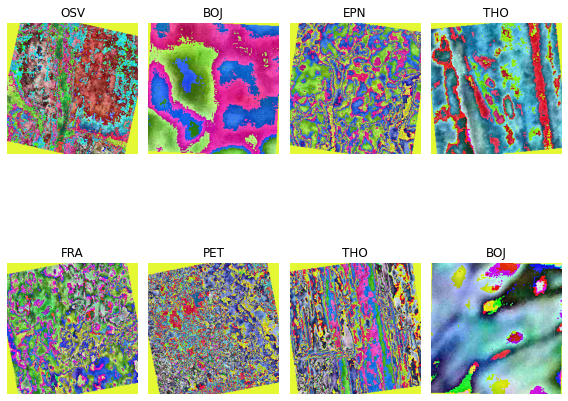

In [12]:
# visualize the training set batch
print("[INFO] visualizing training batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")

[INFO] visualizing validation batch...


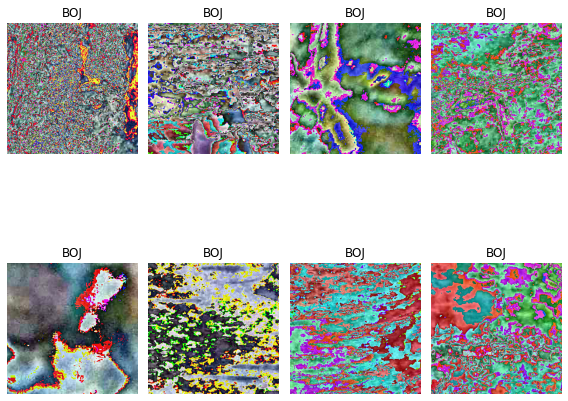

In [13]:
# visualize the validation set batch

print("[INFO] visualizing validation batch...")
visualize_batch(valBatch, valDataset.classes, "val")

## **Class-aware sampling**

### functions

In [14]:
# JH
def get_meta_df(data_set):
    """Works only on BarkNet data set (or similarly structured data). 
    Organizes the meta data of the images is a data frame structure.
    Returns a data frame with one row per image. For each image, 
    following variables are given: 
    - index of image in data set
    - assigned class in data set
    - tree_class ID: <unique tree ID>_<tree species>
    - filename of respective image file
   
    :param  data_set: BarkNet data set (or some data with same structure)
    :type data_set: torch.utils.data.Dataset

    :rtype: pandas.DataFrame
    :return: data frame with meta information for each individual image
    """
    # lists of filenames and classes
    file_list = [x[0] for x in data_set.imgs]
    class_list = [x[1] for x in data_set.imgs]

    # pattern for getting combination of tree_ID and species_ID, eg. '20_BOJ'
    pattern = re.compile('[0-9]+_[A-Z]{3}')

    # extract pattern from filenames
    tree_class = [m.group(0) for string in file_list
                  for m in [pattern.search(string)] if m]

    # maybe include error handling
    # len(tree_class) == len(file_list)

    data_dict = {'indx': list(range(len(data_set))),
                 'class': class_list,
                 'tree_class': tree_class,
                 'file': file_list}

    return pd.DataFrame(data_dict)


In [15]:
# JH
def df_to_class_list(df, return_as='list'):
    """Converts a "meta data frame" (output of get_meta_df()) into 
    one nested list of image indices ordered by class and tree individual. 
    Each list index contains a list for each class of the 
    data set. The lists of each class contain lists with indices for each 
    individual tree of that class.
    Returns a list as default. Can also return a data frame with one row per class
    and a nested list with lists for each tree of the respective class in a column.

    example: [[[2, 3], [5, 6]], [[8, 9], [10, 11]]]: indices [2, 3] and [5, 6]
    belong to two different trees from the same species.

    :param df: a "meta data frame" (output of get_meta_df())
    :type df: pandas.DataFrame
    :param return_as: defaults to "list", for returning one nested list. If "df",
    a data frame will be returned
    :type return_as: str

    :rtype: list or pandas.DataFrame
    :return: nested list or data frame with nested lists of indices in column
    """

    # group df per individual trees and gather indices in lists
    group_tree = df.groupby('tree_class')['indx'].apply(list)

    # make it a df again
    group_tree = pd.DataFrame(group_tree)
    group_tree.reset_index(inplace=True)

    # make df for class IDs
    class_df = df[['class', 'tree_class']].drop_duplicates()

    # join class IDs to df with index-lists
    class_lists_df = class_df.merge(group_tree, on='tree_class', how='left')

    # group by classes and nest all index-lists in one list per class
    class_lists_df = class_lists_df.groupby('class')['indx'].apply(list)

    # make it a df again
    class_lists_df = pd.DataFrame(class_lists_df)
    class_lists_df.reset_index(inplace=True)

    class_lists_df.rename(columns={'indx': 'indx_lists'}, inplace=True)

    # extract lists into one nested list
    class_list = list(class_lists_df['indx_lists'].apply(list))

    if return_as == 'df':
        return class_lists_df
    return class_list


In [16]:
# JH
def class_aware_batch_sampler(batch_size, nested_list, data_set=None):
    """Takes a nested "class-list" (output of df_to_class_list()) and creates
    batches with indices with a "class-aware" sampling routine: For each place 
    in the batch, one of the tree classes is uniformly sampled. From that class,
    one individual tree is randomly sampled. From that tree, one image is 
    randomly sampled and gets into the batch.
    length of the returned list with batches is calculated as total count of 
    items in provided "class-list" divided by the given batch size.
    Default is returning batches of with indices. If data source is provided,
    batches will contain respective elements of the data source as 
    torch.utils.data.Subset.

    :param batch_size: desired size of batches
    :type batch_size: int
    :param nested_list: nested "class-list" (see df_to_class_list())
    :type nested_list: list
    :param data_set: data set that the nested "class-list" refers to
    :type data_set: torch.utils.data.Dataset

    :rtype: list
    :return: list with batches of either indices or dataset subsets
    """

    # list for collecting batches of indices
    idx_list = []
    # list for collecting batches of data belonging to indices in idx_list
    data_batch_list = []
    # count all items in data set
    item_count = 0
    for species in nested_list:
        for tree in species:
            item_count += len(tree)
    # fill each batch
    for batch in range(math.ceil(item_count/batch_size)):
        batch = []
        # fill each batch
        while len(batch) < batch_size:
            # pick random species (list)
            random_species = random.sample(nested_list, k=1)[0]
            if len(random_species) == 0:
                continue
            # pick random individual (list)
            random_individual = random.sample(random_species, k=1)[0]
            if len(random_individual) == 0:
                continue
            # pick random image for that individual and append index to batch list
            idx = random.sample(random_individual, k=1)
            batch += idx
        idx_list.append(batch)
        if data_set is not None:
            # for retrieving the data: 
            # make a torch.Subset with the indices of current batch and append
            data_batch = torch.utils.data.Subset(data_set, batch)
            data_batch_list.append(data_batch)
            
    if data_set is not None:
        return data_batch_list
    return idx_list


In [17]:
# JH
def subset_class_list(class_list, subset_list):
    """Subsets as "nested class-list2 (see df_to_class_list()) by a given 
    list of indices while keeping the original classwise and treewise
    nested structure. Returns a (deep) copy of the original nested list 
    containing only these indices that are present in the provided list 
    with subset indices.

    :param class-list: "nested class-list": indices nested classwiese and treewise
    :type class-list: list
    :param subset-list: list with indices to which the nested list should be susetted
    :type subset-list: list

    :rtype: list
    :return: nested list with only indices present in subset-list but in nested structure
    """
    modified_class_list = copy.deepcopy(class_list)
    for species in modified_class_list:
        for tree in species:
            check_list = copy.deepcopy(tree)
            for image in check_list:
                if image not in subset_list:
                    tree.remove(image)
    return modified_class_list

### get class list with nested lists of image-indices per tree

In [18]:
# JH
# get nested 'class-list' for the training data set 
# (will later be used for 'class-aware' sampling)
df = get_meta_df(data_set=trainDataset)
class_list_df = df_to_class_list(df, 'df')
class_list = df_to_class_list(df)

In [19]:
print(df)

        indx  class tree_class  \
0          0      0     20_BOJ   
1          1      0     20_BOJ   
2          2      0     20_BOJ   
3          3      0     20_BOJ   
4          4      0     20_BOJ   
...      ...    ...        ...   
20939  20939     19    638_THO   
20940  20940     19    638_THO   
20941  20941     19    638_THO   
20942  20942     19    638_THO   
20943  20943     19    638_THO   

                                                    file  
0      data/train/BOJ/20_BOJ_120_GalaxyS7_20170607_15...  
1      data/train/BOJ/20_BOJ_120_GalaxyS7_20170607_15...  
2      data/train/BOJ/20_BOJ_120_GalaxyS7_20170607_15...  
3      data/train/BOJ/20_BOJ_120_GalaxyS7_20170607_15...  
4      data/train/BOJ/20_BOJ_120_GalaxyS7_20170607_15...  
...                                                  ...  
20939  data/train/THO/638_THO_63_GalaxyS7_20170607_15...  
20940  data/train/THO/638_THO_63_GalaxyS7_20170607_15...  
20941  data/train/THO/638_THO_63_GalaxyS7_20170607_15...  
2

In [20]:
print(class_list_df)

    class                                         indx_lists
0       0  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...
1       1  [[1126, 1127, 1128, 1129, 1130, 1131, 1132, 11...
2       2  [[2285, 2286, 2287, 2288, 2289, 2290, 2291, 22...
3       3  [[4723, 4724, 4725, 4726, 4727, 4728, 4729, 47...
4       4  [[5256, 5257, 5258, 5259, 5260, 5261, 5262, 52...
5       5  [[6045, 6046, 6047, 6048, 6049, 6050, 6051, 60...
6       6  [[7249, 7250], [7251, 7252, 7253, 7254, 7255, ...
7       7  [[7909, 7910, 7911, 7912, 7913, 7914, 7915, 79...
8       8  [[9414, 9415, 9416, 9417, 9418, 9419, 9420, 94...
9       9  [[11138, 11139, 11140, 11141, 11142, 11143], [...
10     10  [[12459, 12460, 12461, 12462, 12463, 12464, 12...
11     11  [[13217, 13218, 13219, 13220, 13221, 13222, 13...
12     12  [[14919, 14920, 14921, 14922, 14923, 14924, 14...
13     13  [[15599, 15600, 15601, 15602, 15603, 15604, 15...
14     14  [[16142, 16143, 16144, 16145, 16146, 16147, 16...
15     15  [[17059, 1706

## Subset main data

In [21]:
# JH
def subset_per_tree(data_set, keep=0.5):
    """Reduces the given data set by a given factor with a treewise procedure:
    for each tree individual, only certain proportion of images is kept. 
    Proportion is determined by the keep-factor.
    Since rounding is involved, result is not reduced exactly according to the factor.
    Returns a list with indices of the images that will be kept in the reduced data set.

    :param data_set: data set that is to be subsetted. Needs to be a Dataset of BarkNet
    :type data_set: torch.utils.data.Dataset
    :param keep: proportion of the images per tree to be kept. Number between 0 and 1.
    :type keep: float 

    :rtype: list
    :return: list with indices of images
    """
    lists_df = get_meta_df(data_set)
    lists = df_to_class_list(lists_df)
    subset = []
    for clss in lists:
        for tree in clss:
            subset_tree = random.sample(tree, k=math.floor(len(tree) * keep))
            subset += subset_tree

    return subset

In [22]:
# JH
# subset data sets
train_data_subset = subset_per_tree(trainDataset)
val_data_subset = subset_per_tree(valDataset)

In [23]:
# JH
# get list with class labels
clss_train_data_subset = [trainDataset.targets[i] for i in train_data_subset]
clss_val_data_subset = [valDataset.targets[i] for i in val_data_subset]

In [24]:
# JH
# get list with image files
imgs_train_data_subset = [trainDataset.imgs[i][0] for i in train_data_subset]
imgs_val_data_subset = [valDataset.imgs[i][0] for i in val_data_subset]

In [25]:
# JH
# for reproducibility: save image contained in the subsets
with open('output/train_subset_files.txt', 'w') as train_sub_file:
    for img in imgs_train_data_subset:
        train_sub_file.write('{}\n'.format(img))

with open('output/val_subset_files.txt', 'w') as val_sub_file:
    for img in imgs_val_data_subset:
        val_sub_file.write('{}\n'.format(img))

with open('output/train_files.txt', 'w') as train_file:
    for img in trainDataset.imgs:
        train_file.write('{}\n'.format(img[0]))

with open('output/val_files.txt', 'w') as val_file:
    for img in valDataset.imgs:
        val_file.write('{}\n'.format(img[0]))

In [26]:
# JH
# get number of classes present in the subset (should be the same as before subsetting)
num_classes_train_subset = len(np.unique(clss_train_data_subset))

In [27]:
# JH
# check if all classes are present in both train and validation data
print(np.unique(clss_train_data_subset))
print(np.unique(clss_val_data_subset))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


### dataLoaders for subsetted train and validtion data sets

In [28]:
# JH
# create pytorch Subsets with indices given in subset lists
trainDataSub = torch.utils.data.Subset(trainDataset, train_data_subset)
valDataSub = torch.utils.data.Subset(valDataset, val_data_subset)

# create dataLoaders
trainDataSubLoader = DataLoader(trainDataSub, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
valDataSubLoader = DataLoader(valDataSub, batch_size=config.VAL_BATCH_SIZE, num_workers=2)


### subset nested 'class-list' according to the subset of train data

In [29]:
# JH
"""the nested-class list was created on the complete train data set (since the 
function needs a torch.utils.data.Dataset as input).
to create a class-aware batch sampler for the subsetted train data: class-list
needs to be subsetted according to the train data subset"""
class_list_subset = subset_class_list(class_list=class_list,
                                      subset_list=trainDataSub.indices)

### batch-sampler for 'class-aware' sampling

In [30]:
# JH
# initialize batch sampler for the subsetted train data
batch_list_subset = class_aware_batch_sampler(
    config.TRAIN_BATCH_SIZE,
    nested_list=class_list_subset,
    data_set=trainDataset)

## get information about data and data distributions

### assingment of classes to species


In [31]:
# JH
# get dictionary about how ImageFolder assigned the class numbers
class_to_idx = trainDataset.class_to_idx

In [32]:
# JH
# swap key and value in the dictionary
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

{0: 'BOJ', 1: 'BOP', 2: 'CHR', 3: 'EPB', 4: 'EPN', 5: 'EPO', 6: 'EPR', 7: 'ERR', 8: 'ERS', 9: 'FRA', 10: 'HEG', 11: 'MEL', 12: 'ORA', 13: 'OSV', 14: 'PET', 15: 'PIB', 16: 'PIR', 17: 'PRU', 18: 'SAB', 19: 'THO'}


In [33]:
# JH
# convert dictionary to pandas data frame and save
class_assignment = pd.DataFrame(idx_to_class, index=list(range(1)))
class_assignment = class_assignment.transpose()

In [34]:
class_assignment.to_csv(config.OUTPUT + '/class_assignment.csv')

### images per class and tree

In [35]:
# JH
# train data set: count images per class and tree and save
imgs_class_ID_train = pd.DataFrame(trainDataset.imgs, columns=['img', 'class'])
imgs_class_ID_train[['dir', 'spec', 'img']] = imgs_class_ID_train['img'].str.split(
    '/', 2, expand=True)
imgs_class_ID_train[['ID', 'img']] = imgs_class_ID_train['img'].str.split(
    '_', 1, expand=True)
imgs_class_ID_train = imgs_class_ID_train.groupby(
    ['spec', 'ID'])['img'].count().sort_values()
imgs_class_ID_train = imgs_class_ID_train.reset_index()

imgs_class_ID_train.to_csv(config.OUTPUT + '/images_per_class_and_ID_train.csv')

In [36]:
# JH
# validation data set: count images per class and tree and save
imgs_class_ID_val = pd.DataFrame(valDataset.imgs, columns=['img', 'class'])
imgs_class_ID_val[['dir', 'spec', 'img']] = imgs_class_ID_val['img'].str.split(
    '/', 2, expand=True)
imgs_class_ID_val[['ID', 'img']] = imgs_class_ID_val['img'].str.split(
    '_', 1, expand=True)
imgs_class_ID_val = imgs_class_ID_val.groupby(
    ['spec', 'ID'])['img'].count().sort_values()
imgs_class_ID_val = imgs_class_ID_val.reset_index()

imgs_class_ID_val.to_csv(config.OUTPUT + '/images_per_class_and_ID_val.csv')

In [37]:
# JH
# train data subset: count images per class and tree and save
imgs_class_ID_train_sub = pd.DataFrame({'img': imgs_train_data_subset})
imgs_class_ID_train_sub[['dir', 'spec', 'img']] = imgs_class_ID_train_sub['img'].str.split(
    '/', 2, expand=True)
imgs_class_ID_train_sub[['ID', 'img']] = imgs_class_ID_train_sub['img'].str.split(
    '_', 1, expand=True)
imgs_class_ID_train_sub = imgs_class_ID_train_sub.groupby(
    ['spec', 'ID'])['img'].count().sort_values()
imgs_class_ID_train_sub = imgs_class_ID_train_sub.reset_index()

imgs_class_ID_train_sub.to_csv(config.OUTPUT + '/images_per_class_and_ID_train_sub.csv')

In [38]:
# JH
# validation data subset: count images per class and tree and save
imgs_class_ID_val_sub = pd.DataFrame({'img': imgs_val_data_subset})
imgs_class_ID_val_sub[['dir', 'spec', 'img']] = imgs_class_ID_val_sub['img'].str.split(
    '/', 2, expand=True)
imgs_class_ID_val_sub[['ID', 'img']] = imgs_class_ID_val_sub['img'].str.split(
    '_', 1, expand=True)
imgs_class_ID_val_sub = imgs_class_ID_val_sub.groupby(
    ['spec', 'ID'])['img'].count().sort_values()
imgs_class_ID_val_sub = imgs_class_ID_val_sub.reset_index()

imgs_class_ID_val_sub.to_csv(config.OUTPUT + '/images_per_class_and_ID_val_sub.csv')

## MobileNet v3 small

### get architecture with pre-trained weights and adjust it


In [39]:
# JH
def initialize_mob_net(num_classes):
    """Returns an instance of torchvision.models.mobilenet_v3_small with 
    pretrained weights. First layer gets frozen and classifier gets adjusted 
    to number of classes in the data set that's used.

    :param num_classes: number of classes in the data set
    :type num_classes: int

    :rtype: torchvision.models.mobilenetv3.MobileNetV3
    :return: pretrained mobileNet architecture
    """

    # get architecture with pre-trained weights
    net = torchvision.models.mobilenet_v3_small(pretrained=True)

    # freeze first layer
    net.features[0].requires_grad_(False)

    # adjust output size of last layer
    net.classifier[3] = torch.nn.Linear(
    in_features=1024, out_features=num_classes, bias=True)

    return net

## EfficientNet b0

### get architecture with pre-trained weights and adjust it


In [40]:
# JH
def initialize_effNet_b0(num_classes):
    """Returns an instance of torchvision.models.efficientnet_b0 with 
    pretrained weights. First layer gets frozen and classifier gets adjusted 
    to number of classes in the data set that's used.

    :param num_classes: number of classes in the data set
    :type num_classes: int

    :rtype: torchvision.models.efficientnet_b0
    :return: pretrained EfficientNet architecture
    """
    net = torchvision.models.efficientnet_b0(pretrained=True)

    # freeze first layer
    net.features[0].requires_grad_(False)

    # adjust classifier
    net.classifier[1] = torch.nn.Linear(
    in_features=1280, out_features=num_classes, bias=True)

    return net

## functions for training and validation 

#### train function

In [41]:
# JH
def train(model,
          optimizer,
          train_loader,
          epoch,
          loss_weights=None,
          log_interval=10):
    """trains a given model for a one epoch. Optionally, class weights can be 
    specified and loss will be calculated accordingly. Returns the mean loss per 
    training batch at a given log rate.

    :param model: a network architecture
    :type model: torchvision.model
    :param optimizer: optimizer to be used for training
    :type optimizer: torch.optim
    :param train_loader: data loader for training
    :type train_loader: torch.utils.data.DataLoader
    :param epoch: number of current epoch
    :type epoch: int
    :param loss_weight: class weigths of data set
    :type loss_weight: torch.tensor(..., dtype=torch.float)
    :param log_interval: specifies how often the batch loss is logged
    :type log_interval: int

    :rtype: list
    :return: list with logged mean trining losses per batch
    """
    model.train()
    train_losses = []
    for batch, (data, target) in enumerate(train_loader):
        model.zero_grad()
        # foreward pass
        output = model(data)
        # calculate loss
        if loss_weights is None:
          loss = torch.nn.functional.cross_entropy(output, target)
        else:
          # if class weights are used
          loss = torch.nn.functional.cross_entropy(
              output, target, weight=loss_weights.type('torch.FloatTensor'))
        # backward pass
        loss.backward()
        # optimize
        optimizer.step()
        if batch % log_interval == 0:
            print('Epoch: {}\tbatch {}/{}\tmean loss: {:.2f}'.format(
                epoch + 1, batch + 1, len(train_loader), loss.item()))
            train_losses.append(loss.item())

    return train_losses

#### train function with class-aware sampling

In [42]:
# JH
# train function that uses class-aware sampling
def train_class_aware(model,
          optimizer,
          batch_list,
          epoch,
          loss_weights=None,
          log_interval=10):
    """trains a given model for a one epoch with a class-aware batch sampling. 
    Optionally, class weights can be specified and loss will be calculated 
    accordingly. Instead of DataLoader a batch list is used. This list contains 
    sampled data in one batch per list index. 
    Returns the mean loss per training batch at a given log rate.

    :param model: a network architecture
    :type model: torchvision.model
    :param optimizer: optimizer to be used for training
    :type optimizer: torch.optim
    :param batch_list: list with sampled data batches
    :type batch_list: list
    :param epoch: number of current epoch
    :type epoch: int
    :param loss_weight: class weigths of data set
    :type loss_weight: torch.tensor(..., dtype=torch.float)
    :param log_interval: specifies how often the batch loss is logged
    :type log_interval: int

    :rtype: list
    :return: list with logged mean trining losses per batch
    """
    model.train()
    train_losses = []
    
    for batch_nr, batch in enumerate(iter(batch_list)):
      # a bit more work here since no DataLoader is used
      # images and labes have to be separated in lists
      labels = []
      imgs = []
      for image in batch:
        img = image[0]
        label = image[1]
        imgs.append(img)
        labels.append(label)    

      # lists get stacked so they can be fed to the model
      data = torch.stack(imgs)
      target = torch.tensor(labels)

      model.zero_grad()
      # foreward pass
      output = model(data)
      if loss_weights is None:
        loss = torch.nn.functional.cross_entropy(output, target)
      else:
        # if class weights are used
        loss = torch.nn.functional.cross_entropy(
            output, target, weight=loss_weights.type('torch.FloatTensor'))
      # backward pass
      loss.backward()
      # optimize
      optimizer.step()
      if batch_nr % log_interval == 0:
          print('Epoch: {}\tbatch {}/{}\tmean loss: {:.2f}'.format(
              epoch + 1, batch_nr + 1, len(batch_list), loss.item()))
          train_losses.append(loss.item())

    return train_losses

### function for saving logged train loss

In [43]:
# JH
def loss_log_to_csv(loss_list, path):
    """Write the logged train losses to a specified.    
    Structure is: columns = epoch, rows = batch"""
    
    df = np.array(loss_list).transpose()
    df = pd.DataFrame(df, columns = list(range(df.shape[1])))
    df.to_csv(path)
    print('loss log written to file: ' + path)


### validation function

In [44]:
# JH
def validate(model,
          val_loader):
    """Validates a model with data provided by a DataLoader.
    Returns overall accuracy as well as mean validation loss for 
    for the whole validation data set.
    """
    model.eval()
    mean_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch, (data, target) in enumerate(val_loader):
            if batch % 9 == 0:
              print('Evaluating batch {}/{}'.format(
                  batch + 1, len(val_loader)))
            output = model(data)
            loss = torch.nn.functional.cross_entropy(
                output, target,
                reduction='sum').item()
            prediction = output.data.max(1, keepdim=True)[1]
            correct_predictions += prediction.eq(
                target.data.view_as(prediction)).sum()
            mean_loss += loss / len(val_loader.dataset)
    accuracy = float(correct_predictions / len(val_loader.dataset))
    print('Accuracy: {:.2f}\tmean loss: {:.2f}'.format(
        accuracy, mean_loss))
    
    return [accuracy, mean_loss]


### function for saving logged validation results

In [45]:
# JH
def single_val_to_csv(acc, loss, path):
    """Writes the result of one single evaluation, i.e. one value
    for accuracy and one value for loss, to a file.

    :param acc: accuracy
    :type acc: float
    :param loss: loss
    :type loss: float
    """
    file = open(path, 'w')
    file.write('accuracy,mean_test_loss\n')
    file.write('{},{}'.format(acc, loss))
    file.close()
    print('test result written to file:' + path)

In [46]:
# JH
def val_res_to_csv(acc, mean_loss, path):
    """Writes the logged results of several evaluations to a csv file.

    :param acc: logged accuracies
    :type acc: list
    :param mean_loss: logged validation mean_losses
    :type mean_loss: list
    """
    arr = np.array([acc, mean_loss]).transpose()
    df = pd.DataFrame(arr, columns = ['accuracy', 'mean_loss'])
    df.to_csv(path)
    print('validation results written to: ' + path)

## train mobileNet

In [47]:
# JH
# settings formobileNet
mob_net_learning_rate = 1e-3
mob_net_epochs = 15

In [48]:
# JH
# initialize network
mob_net = initialize_mob_net(num_classes=num_classes_train_subset)

# initialize optimizer
mob_net_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad_, mob_net.parameters()),
    lr=mob_net_learning_rate)

In [ ]:
# JH
# train/eval model

# log results in lists
mob_net_losses = []
mob_net_accuracies = []
mob_net_val_losses = []

for epoch in range(mob_net_epochs):
    train_loss = train(
        model=mob_net,
        epoch=epoch,
        optimizer=mob_net_optimizer,
        train_loader=trainDataSubLoader,
        log_interval=10)
    
    acc, mean_loss = validate(
      model=mob_net,
      val_loader=valDataSubLoader)
    
    mob_net_losses.append(train_loss)
    mob_net_accuracies.append(acc),
    mob_net_val_losses.append(mean_loss)


In [ ]:
# JH
# save model
save_path_mob_net = config.OUTPUT + '/mob_net.pth'
torch.save(mob_net.state_dict(), save_path_mob_net)

In [ ]:
# save logged train loss
loss_log_to_csv(mob_net_losses, path=config.OUTPUT + '/mob_net_losses.csv')

In [ ]:
# JH
# save evaluation results
val_res_to_csv(
    mob_net_accuracies, 
    mob_net_val_losses, 
    config.OUTPUT + '/mob_net_val.csv')

## train mobileNet with class-aware sampling

In [50]:
# JH
# initialize network
mob_net_ca = initialize_mob_net(num_classes=num_classes_train_subset)

# initialize optimizer
mob_net_ca_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad_, mob_net_ca.parameters()),
    lr=mob_net_learning_rate)

In [ ]:
# JH
# train/eval model

mob_net_ca_losses = []
mob_net_ca_accuracies = []
mob_net_ca_val_losses = []

for epoch in range(mob_net_epochs):
    # as mentioned in the report: right here a new batch_list should
    # have been generated. 
    # Simple studpid mistake, but after spotting it there 
    # was no time left to repeat everything.
    train_loss = train_class_aware(
        model=mob_net_ca,
        epoch=epoch,
        optimizer=mob_net_ca_optimizer,
        batch_list=batch_list_subset,
        log_interval=10)
    
    acc, val_loss = validate(
        model=mob_net_ca,
        val_loader=valDataSubLoader)
    
    mob_net_ca_losses.append(train_loss)
    mob_net_ca_accuracies.append(acc)
    mob_net_ca_val_losses.append(val_loss)

In [52]:
# JH
# save model
save_path_mob_net_ca = config.OUTPUT + '/mob_net_ca.pth'
torch.save(mob_net_ca.state_dict(), save_path_mob_net_ca)

In [ ]:
# save train loss
loss_log_to_csv(mob_net_ca_losses, path=config.OUTPUT + '/mob_net_ca_losses.csv')

In [ ]:
# JH
# save validation results
val_res_to_csv(
    mob_net_ca_accuracies, 
    mob_net_ca_val_losses,
    config.OUTPUT + '/mob_net_ca_val.csv')

## train efficientNet

In [54]:
# JH
# settings for EfficientNet
eff_net_learning_rate = 1e-3
eff_net_epochs = 15

In [55]:
# JH
# initialize network
eff_net = initialize_effNet_b0(num_classes=num_classes_train_subset)

# initialize optimizer
eff_net_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad_, eff_net.parameters()),
    lr=eff_net_learning_rate)

In [ ]:
# JH
# train and validate

eff_net_losses = []
eff_net_accuracies = []
eff_net_val_loss = []

for epoch in range(eff_net_epochs):
    train_loss = train(
        model=eff_net,
        epoch=epoch,
        optimizer=eff_net_optimizer,
        train_loader=trainDataSubLoader,
        log_interval=10)
    
    acc, val_loss = validate(
        model=eff_net,
        val_loader=valDataSubLoader)
    
    eff_net_losses.append(train_loss)
    eff_net_accuracies.append(acc)
    eff_net_val_loss.append(val_loss)

In [57]:
# JH
# save model
save_path_eff_net = config.OUTPUT + '/eff_net.pth'
torch.save(eff_net.state_dict(), save_path_eff_net)

In [ ]:
# save logged train losses
loss_log_to_csv(eff_net_losses, path=config.OUTPUT + '/eff_net_losses.csv')

In [ ]:
# JH
# save logged evaluation results
val_res_to_csv(
    eff_net_accuracies, 
    eff_net_val_loss,
    config.OUTPUT + '/eff_net_val.csv')

## test trained EfficientNet with independent test data

In [58]:
# JH
# load independent test data set
"""Problem: it contains only images of three species
if the test data directory would contain only three subdirectories, ImageFolder
would assign different class numbers than on the main data set.
Nice solution: define own Dataset-class
Hacky solution: make directories for all 20 species used in main train data set and
fill each one with a dummy image (ImageFolder won't accept empty directories)
After loading the data via ImageFolder, dummy images will be filtered.
"""

ind_test_dummy = ImageFolder(root=config.INDTEST, transform=valTransforms)

In [59]:
# JH
# drop all dummy images, keep only the three species of which we actually have images
# these three species have the class numbers 2, 5 and 9 in main data set

# get indices of images we want to keep

labels_to_keep = [2, 5, 9]

# gather indices of respective images we want to keep in a list
idx_to_keep = []

for idx in range(len(ind_test_dummy.imgs)):
    if ind_test_dummy.targets[idx] in labels_to_keep:
        idx_to_keep.append(idx)

# check:
for i in idx_to_keep:
    print(ind_test_dummy.imgs[i])

('data/ind_test/CHR/1_CHR_1.jpg', 2)
('data/ind_test/CHR/1_CHR_2.jpg', 2)
('data/ind_test/CHR/1_CHR_3.jpg', 2)
('data/ind_test/CHR/1_CHR_4.jpg', 2)
('data/ind_test/CHR/1_CHR_5.jpg', 2)
('data/ind_test/CHR/2_CHR_1.jpg', 2)
('data/ind_test/CHR/2_CHR_2.jpg', 2)
('data/ind_test/CHR/2_CHR_3.jpg', 2)
('data/ind_test/CHR/2_CHR_4.jpg', 2)
('data/ind_test/CHR/2_CHR_5.jpg', 2)
('data/ind_test/CHR/3_CHR_1.jpg', 2)
('data/ind_test/CHR/3_CHR_2.jpg', 2)
('data/ind_test/CHR/3_CHR_3.jpg', 2)
('data/ind_test/CHR/3_CHR_4.jpg', 2)
('data/ind_test/EPO/1_EPO_1.jpg', 5)
('data/ind_test/EPO/1_EPO_2.jpg', 5)
('data/ind_test/EPO/1_EPO_3.jpg', 5)
('data/ind_test/EPO/1_EPO_4.jpg', 5)
('data/ind_test/EPO/2_EPO_1.jpg', 5)
('data/ind_test/EPO/2_EPO_2.jpg', 5)
('data/ind_test/EPO/2_EPO_3.jpg', 5)
('data/ind_test/EPO/2_EPO_4.jpg', 5)
('data/ind_test/EPO/2_EPO_5.jpg', 5)
('data/ind_test/EPO/2_EPO_6.jpg', 5)
('data/ind_test/EPO/2_EPO_7.jpg', 5)
('data/ind_test/EPO/3_EPO_1.jpg', 5)
('data/ind_test/EPO/3_EPO_2.jpg', 5)
(

In [60]:
# JH
# subset data with list of indices and create data loader
ind_test = torch.utils.data.Subset(ind_test_dummy, idx_to_keep)
ind_test_loader = DataLoader(ind_test, batch_size=5)

### initialize network and load trained weights

In [63]:
# JH
# initialize network
eff_net_test = initialize_effNet_b0(num_classes=20)

# load weights
eff_net_test.load_state_dict(torch.load(config.OUTPUT + '/eff_net.pth'))

<All keys matched successfully>

### run test and save output

In [65]:
# JH
# run the test with the independent test set
test_acc, test_loss = validate(
    model=eff_net_test,
    val_loader=ind_test_loader)

Evaluating batch 1/8
Accuracy: 0.64	mean loss: 1.15


In [66]:
single_val_to_csv(test_acc, test_loss, config.OUTPUT + '/eff_net_ind_test_accuracy.csv')

test result written to file:output/eff_net_ind_test_accuracy.csv


In [67]:
# JH
# get predicted and true labels
pred = []
true = []

for data, targets in ind_test_loader:
    output = eff_net_test(data)

    # retrieve predicted labels
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)

    # retrieve true labels
    target = targets.data.cpu().numpy()
    true.extend(targets)

In [68]:
# JH
# exchange class numbers with species code
# idx_to_class is created with main data set in section 
# 'get information about data and data distributions'
pred_labels = [idx_to_class.get(item, item) for item in pred]
true_labels = [idx_to_class.get(item, item) for item in np.array(true)]

In [69]:
# JH
# make data frame  with label-lists
test_result_label = pd.DataFrame(
    {'pred': pred_labels,
     'true': true_labels})

In [70]:
# JH
# make data frame with class-number lists
test_result = pd.DataFrame(
    {'pred': np.array(pred),
     'true': np.array(true)})

In [71]:
# JH
# save data frames
test_result_label.to_csv(config.OUTPUT + '/eff_net_ind_test_result_label.csv')
test_result.to_csv(config.OUTPUT + '/eff_net_ind_test_result.csv')

### visualize with confusion matrix

In [72]:
# JH
# use pandas crosstab to make confusion matrix with the label-lists
cf_matrix_label = pd.crosstab(
    test_result_label['true'],
    test_result_label['pred'],
    rownames=['true'],
    colnames=['predicted'],
    margins=True,
    margins_name='Total')

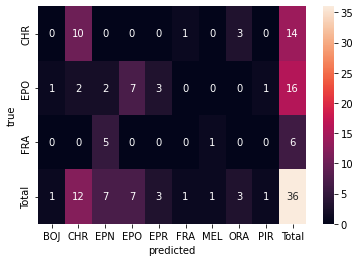

In [73]:
# JH
# plot
plt.clf()
sn.heatmap(cf_matrix_label, annot=True)
plt.show()

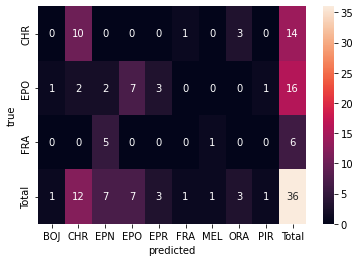

In [74]:
# JH
# save
plt.clf()
sn.heatmap(cf_matrix_label, annot=True)
plt.savefig(
    config.OUTPUT + '/conf_matrix_ind_test_labels.png',
    bbox_inches='tight')